In [0]:
from gym import envs
import gym
from statistics import mean
import numpy as np
import timeit
import matplotlib.pyplot as plt
import matplotlib
from numpy.random import uniform
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
from numpy.random import choice as choose
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D 
from autograd import grad, elementwise_grad
 

In [0]:
env=gym.make('Taxi-v3')

In [0]:
def random_func(num_episodes=1000):
    number_of_steps_in_episodes=[]
    
    for i in range(num_episodes):
        if(i%200==0):
            print("Number of Episodes done "+str(i))
        steps=0
        state=env.reset()
        episode_completed=False
        
        while True:
            action=env.action_space.sample()
            next_state, reward, done, info=env.step(action)
            steps+=1
            if(reward==20):
                #print(reward)
                #env.render()
                episode_complete=True
                break
                #print(reward)
        #print(state)
        number_of_steps_in_episodes.append(steps)

    print("Average Number of steps "+str(mean(number_of_steps_in_episodes)))
            
        

In [0]:
random_func()

Number of Episodes done 0
Number of Episodes done 200
Number of Episodes done 400
Number of Episodes done 600
Number of Episodes done 800
Average Number of steps 2512.091


In [0]:
def get_random_policy(number_of_states,number_of_actions):
    policy=np.random.random(size=(number_of_states,number_of_actions))
    for i in range(number_of_states):
        current_sum=sum(policy[i])
        for j in range(number_of_actions):
            policy[i][j]/=current_sum
    return policy        

In [0]:
def policy_evaluation(policy, env, discount_factor=1.0, theta=0.00001):
    V = np.zeros(env.env.nS)
    while True:
        delta=0 #to be compared against threshold
        #loop for each state
        for state in range(env.env.nS):
            #init value as zero
            s_val=0
            #loop for each action
            for action in range(len(policy[state])):
                p_action=policy[state][action]
                #finding transition probabilty, next state, reward
                for transition_prob,next_state,reward,done in env.env.P[state][action]:
                    s_val+=p_action*transition_prob*(discount_factor*V[next_state]+reward)
            delta=max(delta,abs(s_val-V[state]))
            V[state]=s_val;
        if(delta<theta):
            break
    return np.array(V)

In [0]:
def policy_iteration(env, policy_eval_fn=policy_evaluation, discount_factor=1.0):
    def one_step_lookahead(state, V):
        A=np.zeros(env.env.nA)
        for action in range(len(A)):
            for transition_prob,next_state,reward,done in env.env.P[state][action]:
                A[action]+=transition_prob*(discount_factor*V[next_state]+reward)
        return np.array(A)
    policy=get_random_policy(env.env.nS,env.env.nA)
    steps=0
    while True:
        stable=True
        steps+=1
        current_pol_eval=policy_eval_fn(policy,env,discount_factor)
        for state in range(env.env.nS):
            old_action=np.argmax(policy[state])
            new_action_vals=one_step_lookahead(state,current_pol_eval)
            best_action=np.argmax(new_action_vals)
            if(best_action!=old_action):
                stable=False
            new_state_policy=np.zeros(env.env.nA)
            new_state_policy[best_action]=1
            policy[state]=new_state_policy
        if stable:
            return policy, current_pol_eval,steps
    return policy,np.random.random(env.env.nS),steps



In [0]:
def value_iteration(env, theta=0.0001, discount_factor=1.0): 
    def one_step_lookahead(state, V):
        A=np.zeros(env.env.nA)
        for action in range(len(A)):
            for transition_prob,next_state,reward,done in env.env.P[state][action]:
                A[action]+=transition_prob*(discount_factor*V[next_state]+reward)
        return np.array(A)
    
    V = np.zeros(env.env.nS)
    steps=0
    while True:
        delta=0
        steps+=1
        for state in range(env.env.nS):
            action_values=one_step_lookahead(state,V)
            delta=max(delta,abs(V[state]-max(action_values)))
            V[state]=max(action_values)
        if theta>delta:
            break
    #ret deterministic policy
    policy=np.zeros(shape=(env.env.nS,env.env.nA))
    for state in range(env.env.nS):
        action_values=one_step_lookahead(state,V)
        policy[state][np.argmax(action_values)]=1

    return policy, V,steps

In [0]:
env.reset()
value_iter_policy, value_iter_states,value_iter_steps=value_iteration(env,discount_factor=0.99)

In [0]:
def check_same_policy(policy_a,policy_b):
    for i in range(len(policy_a[:,0])):
        if (policy_a[i]==policy_b[i]).all():
            continue
        else:
            return False
    return True
        

In [0]:
gamma=0.01
my_theta=1e-35
false_count=0
env.reset()
value_iter_policy, value_iter_states,value_iter_steps=value_iteration(env,theta=my_theta,discount_factor=gamma)
number_of_steps_per_gamma_val_iter=[]
number_of_steps_per_gamma_val_iter.append((gamma,value_iter_steps))
prev_policy=value_iter_policy
while True:
    gamma+=0.05
    if(gamma>=1):
        break
    env.reset()
    value_iter_policy, value_iter_states,value_iter_steps=value_iteration(env,theta=my_theta,discount_factor=gamma)
    if not(check_same_policy(prev_policy,value_iter_policy)):
        false_count+=1
    prev_policy=value_iter_policy
    number_of_steps_per_gamma_val_iter.append((gamma,value_iter_steps))
print(false_count)

8


In [0]:
start_time = timeit.default_timer()
value_iter_policy, value_iter_states,value_iter_steps=value_iteration(env,theta=1e-5,discount_factor=0.99)
elapsed = timeit.default_timer() - start_time
print("Time Taken " + str(elapsed))

Time Taken 4.96387042599963


In [0]:
start_time = timeit.default_timer()
policy_iter_policy, policy_iter_states,policy_iter_steps=policy_iteration(env,discount_factor=0.99)
elapsed = timeit.default_timer() - start_time
print("Time Taken " + str(elapsed))

Time Taken 96.61303912899893


In [0]:
print("Steps Taken ",value_iter_steps)

Steps Taken  1666


In [0]:
number_of_steps_per_gamma_val_iter

[(0.01, 10),
 (0.060000000000000005, 14),
 (0.11000000000000001, 17),
 (0.16000000000000003, 17),
 (0.21000000000000002, 19),
 (0.26, 21),
 (0.31, 24),
 (0.36, 25),
 (0.41, 29),
 (0.45999999999999996, 31),
 (0.51, 35),
 (0.56, 41),
 (0.6100000000000001, 48),
 (0.6600000000000001, 53),
 (0.7100000000000002, 65),
 (0.7600000000000002, 77),
 (0.8100000000000003, 96),
 (0.8600000000000003, 129),
 (0.9100000000000004, 198),
 (0.9600000000000004, 440)]

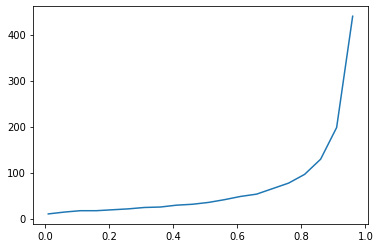

In [0]:
x,y=zip(*number_of_steps_per_gamma_val_iter)
plt.plot(x,y)

In [0]:
gamma=0.99
my_theta=1e-20
false_count=0
env.reset()
start_time = timeit.default_timer()
policy_iter_policy, policy_iter_states,policy_iter_steps=policy_iteration(env,discount_factor=gamma)
elapsed = timeit.default_timer() - start_time
number_of_steps_per_gamma_policy_iter=[]
number_of_steps_per_gamma_policy_iter.append((gamma,policy_iter_steps))
prev_policy=policy_iter_policy
while True:
    print(gamma)
    gamma+=0.05
    if(gamma>=1):
        break
    env.reset()
    policy_iter_policy, policy_iter_states,policy_iter_steps=policy_iteration(env,discount_factor=gamma)
    if not(check_same_policy(prev_policy,policy_iter_policy)):
        false_count+=1
    prev_policy=policy_iter_policy
    number_of_steps_per_gamma_policy_iter.append((gamma,policy_iter_steps))
print(false_count)
print("Time Taken" + str(elapsed))

0.99
0
Time Taken87.78651969100065


In [0]:
print("Steps Taken ",policy_iter_steps)

Steps Taken  15


In [0]:
check_same_policy(policy_iter_policy,value_iter_policy)

True

In [0]:
num_separate_action=0
for i in range(env.env.nS):
    if(np.argmax(policy_iter_policy[i])!=np.argmax(value_iter_policy[i])):
        num_separate_action+=1
print("Out of "+str(env.env.nS)+" states, "+str(num_separate_action)+" states have different best actions in these policies")

Out of 500 states, 50 states have different best actions in these policies


In [0]:
gamma=0.99
my_theta=1e-20
false_count=0
env.reset()
start_time = timeit.default_timer()
policy_iter_policy, policy_iter_states,policy_iter_steps=policy_iteration(env,discount_factor=gamma)
elapsed = timeit.default_timer() - start_time
number_of_steps_per_gamma_policy_iter=[]
number_of_steps_per_gamma_policy_iter.append((gamma,policy_iter_steps))
prev_policy=policy_iter_policy
while True:
    print(gamma)
    print("Steps: " +str(number_of_steps_per_gamma_policy_iter[-1]))
    gamma-=0.05
    if(gamma<0):
        break
    env.reset()
    policy_iter_policy, policy_iter_states,policy_iter_steps=policy_iteration(env,discount_factor=gamma)
    if not(check_same_policy(prev_policy,policy_iter_policy)):
        false_count+=1
    prev_policy=policy_iter_policy
    number_of_steps_per_gamma_policy_iter.append((gamma,policy_iter_steps))
print(false_count)
print("Time Taken" + str(elapsed))

0.99
Steps: (0.99, 14)
0.94
Steps: (0.94, 14)
0.8899999999999999
Steps: (0.8899999999999999, 14)
0.8399999999999999
Steps: (0.8399999999999999, 15)
0.7899999999999998
Steps: (0.7899999999999998, 15)
0.7399999999999998
Steps: (0.7399999999999998, 16)
0.6899999999999997
Steps: (0.6899999999999997, 14)
0.6399999999999997
Steps: (0.6399999999999997, 14)
0.5899999999999996
Steps: (0.5899999999999996, 15)
0.5399999999999996
Steps: (0.5399999999999996, 14)
0.4899999999999996
Steps: (0.4899999999999996, 15)
0.4399999999999996
Steps: (0.4399999999999996, 13)
0.3899999999999996
Steps: (0.3899999999999996, 16)
0.33999999999999964
Steps: (0.33999999999999964, 15)


KeyboardInterrupt: ignored

In [0]:
def policy_count(policy,num_episodes=1000):
    number_of_steps_in_episodes=[] 
    for i in range(num_episodes):
        if(i%200==0):
            print("Number of Episodes done "+str(i))
        steps=0
        state=env.reset()
        episode_completed=False
        
        while True:
            action=np.argmax(policy[state])
            next_state, reward, done, info=env.step(action)
            steps+=1
            state=next_state
            if(reward==20):
                #print(reward)
                #env.render()
                episode_complete=True
                break
                #print(reenv.action_spacward)
        #print(state)
        number_of_steps_in_episodes.append(steps)

    print("Average Number of steps "+str(mean(number_of_steps_in_episodes)))
    plt.plot(number_of_steps_in_episodes,'ro',markersize=1)
    number_of_steps_in_episodes.sort()
    plt.plot(number_of_steps_in_episodes,'b',markersize=1)
            
       

Number of Episodes done 0
Number of Episodes done 200
Number of Episodes done 400
Number of Episodes done 600
Number of Episodes done 800
Average Number of steps 13.061


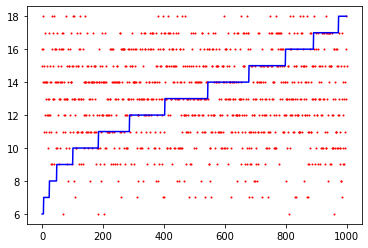

In [0]:
policy_count(value_iter_policy,1000)

Number of Episodes done 0
Number of Episodes done 200
Number of Episodes done 400
Number of Episodes done 600
Number of Episodes done 800
Average Number of steps 13.261


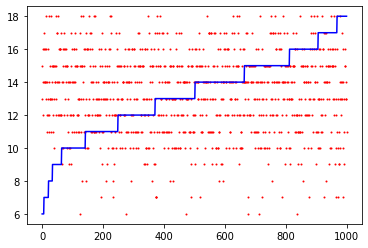

In [0]:
policy_count(policy_iter_policy,1000)

In [0]:
def Q_learning_train(env,alpha,gamma,epsilon,episodes): 
    q_table = np.zeros([env.observation_space.n, env.action_space.n])  
    rewards=[]
    for i in range(1, episodes+1):
        cur_reward=0
        state = env.reset()
        steps=0
        while True:
            random_val=uniform(0,1)
            if(random_val>epsilon):
                action=np.argmax(q_table[state])
            else:
                action=env.action_space.sample()
            next_state,reward,done,info=env.step(action)
            cur_reward+=reward
            q_table[state][action] = q_table[state][action] + alpha * (reward + gamma * max(q_table[next_state])-q_table[state][action])
            state=next_state
            if done:
                rewards.append(cur_reward)
                break
            steps+=1

        if(i%200==0):
            print("Episode: ",i)

       # Start with a random policy
    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    for state in range(env.env.nS):  #for each states
        #Extract the best optimal policy found so far
        policy[state]=np.zeros(env.env.nA)
        policy[state][np.argmax(q_table[state])]=1

    
    return policy, q_table,rewards

In [0]:
env.reset()
alphas=[]
num_episodes=500
rewards_per_alpha=[]
alpha=0.1
while alpha<1: 
    print(alpha)   
    alphas.append(alpha)
    q_policy,q_table,q_rewards=Q_learning_train(env,alpha,0.98,0.15,num_episodes)
    rewards_per_alpha.append(sum(q_rewards)/num_episodes)
    alpha+=0.1

0.1
Episode:  200
Episode:  400
0.2
Episode:  200
Episode:  400
0.30000000000000004
Episode:  200
Episode:  400
0.4
Episode:  200
Episode:  400
0.5
Episode:  200
Episode:  400
0.6
Episode:  200
Episode:  400
0.7
Episode:  200
Episode:  400
0.7999999999999999
Episode:  200
Episode:  400
0.8999999999999999
Episode:  200
Episode:  400
0.9999999999999999
Episode:  200
Episode:  400


Text(0, 0.5, 'Average reward per episode')

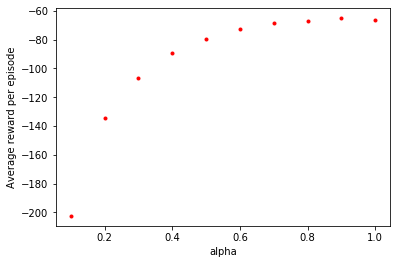

In [0]:
plt.plot(alphas,rewards_per_alpha,'ro',markersize=3)
plt.xlabel('alpha')
plt.ylabel('Average reward per episode')

In [0]:
num_episodes=1000
q_policy,q_table,q_rewards=Q_learning_train(env,0.9,0.98,0.15,num_episodes)

Episode:  200
Episode:  400
Episode:  600
Episode:  800
Episode:  1000


Text(0, 0.5, 'Sum of rewards during episode')

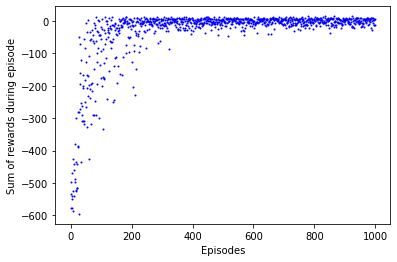

In [0]:
plt.plot(q_rewards,'bo',markersize=1)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')

In [0]:
env = gym.envs.make("MountainCar-v0")


In [0]:

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
num_samples=99999
observation_examples = [env.observation_space.sample() for x in range(num_samples)]
observation_examples=np.array(observation_examples)

In [0]:
scaler = sklearn.preprocessing.StandardScaler().fit(observation_examples)

In [0]:
featurizer = sklearn.pipeline.FeatureUnion([
        ("layer1", RBFSampler(gamma=5.0, n_components=64)),
        ("layer2", RBFSampler(gamma=1.0, n_components=64)),
        ("layer3", RBFSampler(gamma=2.0, n_components=64)),
        ("layer4", RBFSampler(gamma=0.5, n_components=64))
        ],verbose=True)
featurizer.fit(scaler.transform(observation_examples))

[FeatureUnion] ........ (step 1 of 4) Processing layer1, total=   0.0s
[FeatureUnion] ........ (step 2 of 4) Processing layer2, total=   0.0s
[FeatureUnion] ........ (step 3 of 4) Processing layer3, total=   0.0s
[FeatureUnion] ........ (step 4 of 4) Processing layer4, total=   0.0s


FeatureUnion(n_jobs=None,
             transformer_list=[('layer1',
                                RBFSampler(gamma=5.0, n_components=64,
                                           random_state=None)),
                               ('layer2',
                                RBFSampler(gamma=1.0, n_components=64,
                                           random_state=None)),
                               ('layer3',
                                RBFSampler(gamma=2.0, n_components=64,
                                           random_state=None)),
                               ('layer4',
                                RBFSampler(gamma=0.5, n_components=64,
                                           random_state=None))],
             transformer_weights=None, verbose=True)

In [0]:
class Estimator():
    def featurize_state(self, state):
        return featurizer.transform(scaler.transform([state]))[0]    
    def predict(self, s, a=None):
        if a is None:
            return np.array([self.models[i].predict([self.featurize_state(s)]) for i in range(env.action_space.n)]).reshape(-1)
        return self.models[a].predict([self.featurize_state(s)])[0]
    def __init__(self):
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    def update(self, s, a, y):
        self.models[a].partial_fit([self.featurize_state(s)], [y])

In [0]:

def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    to_plot=[]
    first_episode=[]
    last_reward=0
    rewards_per_episode=[]
    steps_per_episode=[]
    for i_episode in range(num_episodes):
        def policy(state):
            eps=epsilon * epsilon_decay**i_episode
            A=np.ones(env.action_space.n,dtype=float)*eps/env.action_space.n
            q_vals=estimator.predict(state)
            A[np.argmax(q_vals)]=1.0-eps+eps/env.action_space.n
            return A
        est=deepcopy(estimator)
        to_plot.append(est)

        if(i_episode!=0):
            print("Episode: "+ str(i_episode) + " Reward: "+str(last_reward))

            rewards_per_episode.append(last_reward)
            steps_per_episode.append(steps)
        state = env.reset()
        steps=0
        last_reward=0
        done=False
        while True:
            if done:
                break
            steps+=1
            action = choose(env.action_space.n, p=policy(state))
            new_state, reward, done, info = env.step(action)
            last_reward+=reward
            new_action = choose(env.action_space.n, p=policy(new_state))                        
            estimator.update(state, action, reward + discount_factor * np.max(estimator.predict(new_state)))            
            state = new_state
            if(i_episode==0):
                first_episode.append(deepcopy(estimator))

    return to_plot,first_episode
    

In [0]:
from mpl_toolkits.mplot3d import Axes3D

In [0]:
est=Estimator()
to_plot,first_episode=q_learning(env, est, 500, epsilon=0.01)

Episode: 1 Reward: -200.0
Episode: 2 Reward: -200.0
Episode: 3 Reward: -200.0
Episode: 4 Reward: -200.0
Episode: 5 Reward: -200.0
Episode: 6 Reward: -200.0
Episode: 7 Reward: -200.0
Episode: 8 Reward: -200.0
Episode: 9 Reward: -200.0
Episode: 10 Reward: -200.0
Episode: 11 Reward: -200.0
Episode: 12 Reward: -200.0
Episode: 13 Reward: -200.0
Episode: 14 Reward: -200.0
Episode: 15 Reward: -200.0
Episode: 16 Reward: -200.0
Episode: 17 Reward: -200.0
Episode: 18 Reward: -200.0
Episode: 19 Reward: -200.0
Episode: 20 Reward: -200.0
Episode: 21 Reward: -200.0
Episode: 22 Reward: -200.0
Episode: 23 Reward: -200.0
Episode: 24 Reward: -200.0
Episode: 25 Reward: -200.0
Episode: 26 Reward: -200.0
Episode: 27 Reward: -200.0
Episode: 28 Reward: -200.0
Episode: 29 Reward: -200.0
Episode: 30 Reward: -200.0
Episode: 31 Reward: -200.0
Episode: 32 Reward: -200.0
Episode: 33 Reward: -200.0
Episode: 34 Reward: -200.0
Episode: 35 Reward: -161.0
Episode: 36 Reward: -172.0
Episode: 37 Reward: -200.0
Episode: 3

In [0]:
def plot_cost_to_go_mountain_car(env, est):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=20)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=20)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(est.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                            cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")

    plt.show()

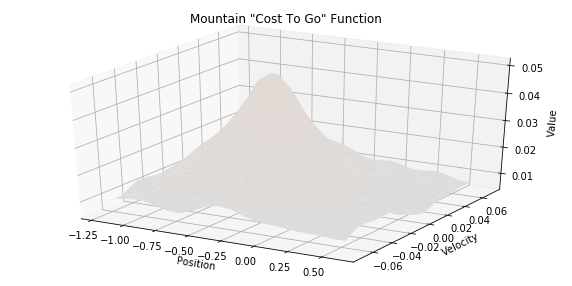

In [0]:
plot_cost_to_go_mountain_car(env,first_episode[2])

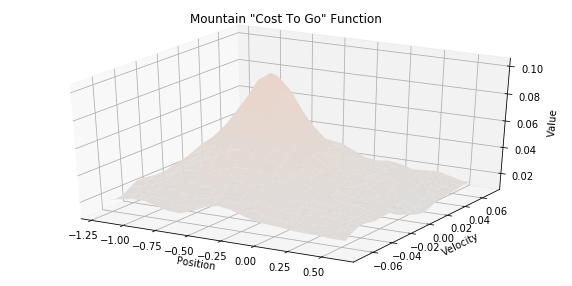

In [0]:
plot_cost_to_go_mountain_car(env,first_episode[5])

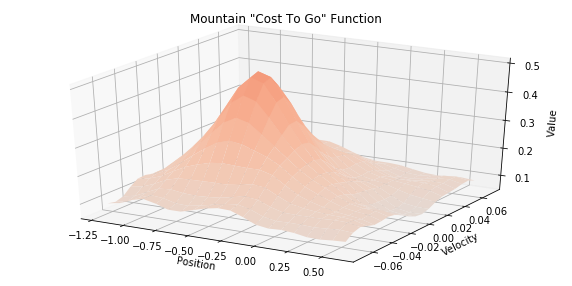

In [0]:
plot_cost_to_go_mountain_car(env,first_episode[30])

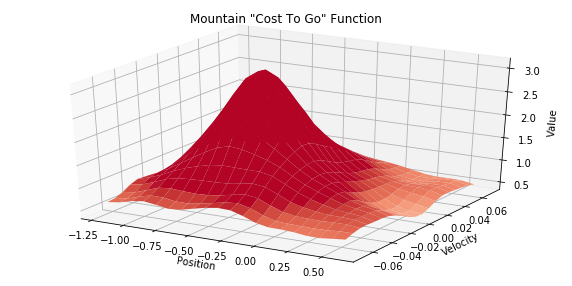

In [0]:
plot_cost_to_go_mountain_car(env,to_plot[1])

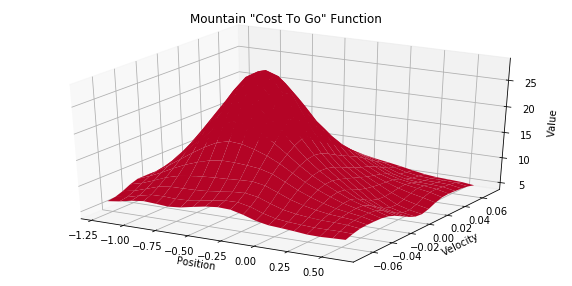

In [0]:
plot_cost_to_go_mountain_car(env,to_plot[10])

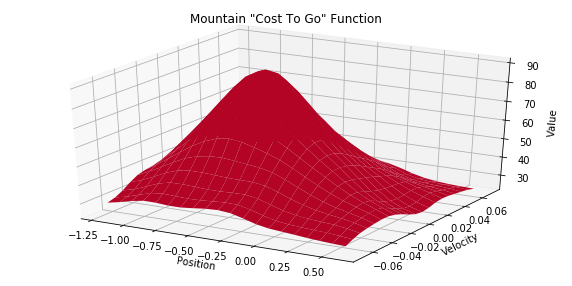

In [0]:
plot_cost_to_go_mountain_car(env,to_plot[50])

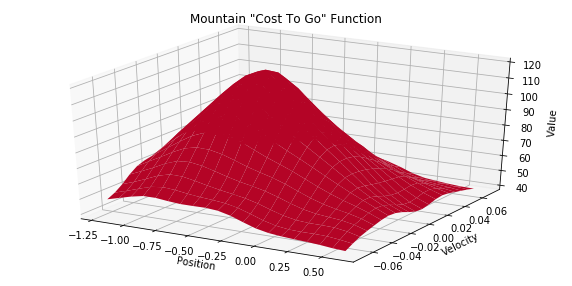

In [0]:
plot_cost_to_go_mountain_car(env,to_plot[100])

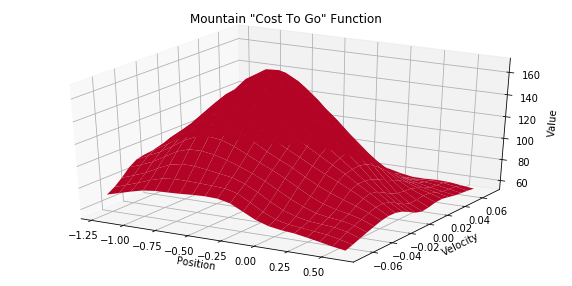

In [0]:
plot_cost_to_go_mountain_car(env,to_plot[300])

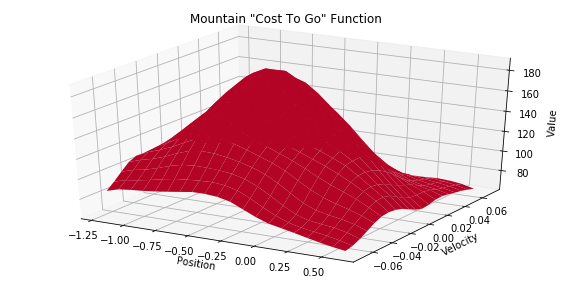

In [0]:
plot_cost_to_go_mountain_car(env,to_plot[499])

In [0]:
env = gym.make('CartPole-v0')
actions=[0,1]

In [0]:
def q_learning_cart(episodes,discount_factor,epsilon,alpha):
    weights=np.random.random((4,2))
    def approx(weights,state,action):
        return np.dot(state,weights)[action]
    dapprox=grad(approx)
    state=env.reset()
    reward_per_episode=[]
    for i_episode in range(episodes):
        rewards_this_episode=0

        

        while True:
            qs=[]
            for action in actions:
                qs.append(approx(weights, state, action))
            choice_num=uniform(0,1)
            if(choice_num<epsilon):
                action=choose(actions)
            else:
                action=np.argmax(qs)
            q_hat = approx(weights, state, action)
            q_hat_grad = dapprox(weights, state, action)
            next_state, reward, done, _ = env.step(action)
            rewards_this_episode+=reward
            if done:
                weights+=alpha*(reward - q_hat) * q_hat_grad
                break

            qs=[]
            for action in actions:
                qs.append(approx(weights, next_state, action))
            choice_num=uniform(0,1)
            if(choice_num<epsilon):
                next_action=choose(actions)
            else:
                next_action=np.argmax(qs)
            q_hat_next = approx(weights, next_state, next_action)
            weights += alpha*(reward - discount_factor*q_hat_next)*q_hat_grad
            state=next_state
        reward_per_episode.append(rewards_this_episode)
        state=env.reset()
 
    return reward_per_episode,weights


In [0]:
rewards_per_episode,weights=q_learning_cart(1000,0.99,0.1,0.1)

In [0]:
#Doesnt work in colab. Run on offline jupyter
state = env.reset()
step = 0
def approx(weights,state,action):
    return np.dot(state,weights)[action]
epsilon=0.1

while True:
    step += 1
    qs=[]
    for action in actions:
        qs.append(approx(weights, state, action))
    choice_num=uniform(0,1)
    if(choice_num<epsilon):
        next_action=choose(actions)
    else:
        next_action=np.argmax(qs)
    state, _, done, _ = env.step(next_action)
    env.render()
    if done:
        break

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
#tile coding try

In [0]:
numTilings = 8
tilingSize = 8 
position_min=-1.2
position_max=0.5
velocity_min=-0.07
velocity_max=0.07
positionTileMovementValue = -(position_min-position_max)/(numTilings*tilingSize)
velocityTileMovementValue = -(velocity_min-velocity_max)/(numTilings*tilingSize)

In [0]:
def tilecode(x,y,tileIndices):
    x = x -position_min
    y = y -velocity_min

    for i in range (numTilings):	
        xcoord = int(tilingSize * (x- i * positionTileMovementValue)/1.7)
        ycoord = int(tilingSize * (y- i * velocityTileMovementValue)/0.14)

        tileIndices[i] = i * 81 + ( ycoord * 9 + xcoord)